In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from utils import mnist, plot_graphs, plot_mnist
import numpy as np

%matplotlib inline

In [2]:
mnist_transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Normalize((0.5,), (0.5,)),
           ])
train_loader, valid_loader, test_loader = mnist(valid=10000, transform=mnist_transform)

In [3]:
class ConvLayer(nn.Module):
    def __init__(self, size, padding=1, pool_layer=nn.MaxPool2d(2, stride=2),
                 bn=False, dropout=False, activation_fn=nn.ReLU(), stride=1):
        super(ConvLayer, self).__init__()
        layers = []
        layers.append(nn.Conv2d(size[0], size[1], size[2], padding=padding, stride=stride))
        if pool_layer is not None:
            layers.append(pool_layer)
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

class DeconvLayer(nn.Module):
    def __init__(self, size, padding=1, stride=1, 
                 bn=False, dropout=False, activation_fn=nn.ReLU(), output_padding=0):
        super(DeconvLayer, self).__init__()
        layers = []
        layers.append(nn.ConvTranspose2d(size[0], size[1], size[2], padding=padding, 
                                         stride=stride, output_padding=output_padding))
        if bn:
            layers.append(nn.BatchNorm2d(size[1]))
        if dropout:
            layers.append(nn.Dropout2d())
        layers.append(activation_fn)
        
        self.model = nn.Sequential(*layers)
    
    def forward(self, x):
        return self.model(x)

In [4]:
class FullyConnected(nn.Module):
    def __init__(self, sizes, dropout=False, activation_fn=nn.Tanh):
        super(FullyConnected, self).__init__()
        layers = []
        
        for i in range(len(sizes) - 2):
            layers.append(nn.Linear(sizes[i], sizes[i+1]))
            if dropout:
                layers.append(nn.Dropout())
            layers.append(activation_fn())
        else: # нам не нужен дропаут и фнкция активации в последнем слое
            layers.append(nn.Linear(sizes[-2], sizes[-1]))
        
        self.model = nn.Sequential(*layers)
        
    def forward(self, x):
        return self.model(x)

In [5]:
class Net(nn.Module):
    def __init__(self, batchnorm=False, dropout=False, sparse=None, rho=1., optim_type='SGD', **optim_params):
        super(Net, self).__init__()
        
        self.sparse = sparse
        self.rho = rho
        
        self._conv1 = ConvLayer([1, 16, 4], padding=0, bn=batchnorm, stride=2, pool_layer=None)
        self._conv2 = ConvLayer([16, 32, 4], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        self._conv3 = ConvLayer([32, 32, 3], padding=0, bn=batchnorm, stride=2, 
                                pool_layer=None, activation_fn=nn.Tanh())
        
        if self.sparse == 'KL':
            self.latent_fn = nn.Sigmoid()
        else:
            self.latent_fn = nn.Tanh()
            
        self.fce = FullyConnected([32*2*2, 32])
        self.fcd = FullyConnected([32, 32*2*2])
        
        self._deconv1 = DeconvLayer([32, 32, 3], stride=2, padding=0, bn=batchnorm)
        self._deconv2 = DeconvLayer([32, 16, 4], stride=2, padding=0, bn=batchnorm, output_padding=1)
        self._deconv3 = DeconvLayer([16, 1, 4], stride=2, padding=0, bn=batchnorm, activation_fn=nn.Tanh())
        
        self._loss = None
        if optim_type == 'SGD':
            self.optim = optim.SGD(self.parameters(), **optim_params)
        elif optim_type == 'Adadelta':
            self.optim = optim.Adadelta(self.parameters(), **optim_params)
        elif optim_type == 'RMSProp':
            self.optim = optim.RMSprop(self.parameters(), **optim_params)
        elif optim_type == 'Adam':
            self.optim = optim.Adam(self.parameters(), **optim_params)
        
    def conv(self, x):
        l1 = self._conv1(x)       
        l2 = self._conv2(l1)        
        l3 = self._conv3(l2)     
        return l3, l2, l1
    
    def encode(self, x):
        l3 = self.conv(x)[0]       
        flatten = l3.view(-1, 32*2*2)       
        self.h = self.latent_fn(self.fce(flatten))
        return self.h
    
    def decode(self, h):
        flatten = self.fcd(h)
        l1 = flatten.view(-1, 32, 2, 2)
        l2 = self._deconv1(l1)
        l3 = self._deconv2(l2)
        x = self._deconv3(l3)
        return x
        
    def forward(self, x):        
        h = self.encode(x)        
        x = self.decode(h)
        return x
    
    def loss(self, output, target):
        if self.sparse == 'KL':
            h_mean = self.h.mean(0)
            sparse_loss = - torch.log(h_mean) * self.rho - torch.log(1-h_mean) * (1-self.rho)
            self.sparse_loss = sparse_loss.mean()
        elif self.sparse == 'L1':
            h_abs = torch.abs(self.h)
            self.sparse_loss = self.rho * h_abs.mean()
        else:
            self.sparse_loss = 0.
                   
        self._loss = F.mse_loss(output, target) + self.sparse_loss
        
        return self._loss

In [6]:
models = {
    'RMSProp KL': Net(False, False, sparse='KL', rho=0.2, optim_type='RMSProp', lr=1e-4),
    'RMSProp+bn L1': Net(True, False, sparse='L1', rho=0.01, optim_type='RMSProp', lr=1e-4),    
    'Adam KL': Net(False, False, sparse='KL', rho=0.2, optim_type='Adam', lr=1e-4),
    'Adam L1': Net(False, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4),
    'Adam+bn L1': Net(True, False, sparse='L1', rho=0.01, optim_type='Adam', lr=1e-4)
}
train_log = {k: [] for k in models}
test_log = {k: [] for k in models}

In [7]:
def train(epoch, models, log=None):
    train_size = len(train_loader.sampler)
    for batch_idx, (data, _) in enumerate(train_loader):
        for model in models.values():
            model.optim.zero_grad()
            output = model(data)             
            loss = model.loss(output, data)
            loss.backward()
            model.optim.step()
            
        if batch_idx % 200 == 0:
            line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
                epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
            losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
            print(line + losses)
            
    else:
        batch_idx += 1
        line = 'Train Epoch: {} [{}/{} ({:.0f}%)]\tLosses '.format(
            epoch, batch_idx * len(data), train_size, 100. * batch_idx / len(train_loader))
        losses = ' '.join(['{}: {:.6f}'.format(k, m._loss.item()) for k, m in models.items()])
        if log is not None:
            for k in models:
                log[k].append((models[k]._loss,))
        print(line + losses)

In [8]:
def test(models, loader, log=None):
    test_size = len(loader)
    test_loss = {k: 0. for k in models}
    with torch.no_grad():
        for data, _ in loader:
            output = {k: m(data) for k, m in models.items()}
            for k, m in models.items():
                test_loss[k] += m.loss(output[k], data).item() # sum up batch loss
    
    for k in models:
        test_loss[k] /= test_size
    report = 'Test losses: ' + ' '.join(['{}: {:.8f}\n'.format(k, test_loss[k]) for k in test_loss])
    if log is not None:
        for k in models:
            log[k].append((test_loss[k],))
    print(report)

In [9]:
for epoch in range(1, 41):
    for model in models.values():
        model.train()
    train(epoch, models, train_log)
    for model in models.values():
        model.eval()
    test(models, valid_loader, test_log)

Train Epoch: 1 [0/50000 (0%)]	Losses RMSProp KL: 1.577977 RMSProp+bn L1: 0.947815 Adam KL: 1.713478 Adam L1: 0.994375 Adam+bn L1: 1.026012
Train Epoch: 1 [10000/50000 (20%)]	Losses RMSProp KL: 1.030291 RMSProp+bn L1: 0.781150 Adam KL: 1.201927 Adam L1: 0.576395 Adam+bn L1: 0.694672
Train Epoch: 1 [20000/50000 (40%)]	Losses RMSProp KL: 0.933404 RMSProp+bn L1: 0.733330 Adam KL: 1.007895 Adam L1: 0.465400 Adam+bn L1: 0.629646
Train Epoch: 1 [30000/50000 (60%)]	Losses RMSProp KL: 0.881318 RMSProp+bn L1: 0.689006 Adam KL: 0.935543 Adam L1: 0.423948 Adam+bn L1: 0.578692
Train Epoch: 1 [40000/50000 (80%)]	Losses RMSProp KL: 0.837672 RMSProp+bn L1: 0.648094 Adam KL: 0.895229 Adam L1: 0.397659 Adam+bn L1: 0.539257
Train Epoch: 1 [50000/50000 (100%)]	Losses RMSProp KL: 0.807487 RMSProp+bn L1: 0.608507 Adam KL: 0.878132 Adam L1: 0.377559 Adam+bn L1: 0.505574
Test losses: RMSProp KL: 0.80340754
 RMSProp+bn L1: 0.60807409
 Adam KL: 0.87414737
 Adam L1: 0.37288640
 Adam+bn L1: 0.50662821

Train Epoc

Train Epoch: 9 [20000/50000 (40%)]	Losses RMSProp KL: 0.590343 RMSProp+bn L1: 0.055833 Adam KL: 0.581609 Adam L1: 0.042994 Adam+bn L1: 0.071304
Train Epoch: 9 [30000/50000 (60%)]	Losses RMSProp KL: 0.586877 RMSProp+bn L1: 0.054356 Adam KL: 0.573985 Adam L1: 0.039615 Adam+bn L1: 0.069043
Train Epoch: 9 [40000/50000 (80%)]	Losses RMSProp KL: 0.583227 RMSProp+bn L1: 0.048767 Adam KL: 0.568807 Adam L1: 0.037689 Adam+bn L1: 0.064221
Train Epoch: 9 [50000/50000 (100%)]	Losses RMSProp KL: 0.597060 RMSProp+bn L1: 0.053988 Adam KL: 0.583959 Adam L1: 0.045244 Adam+bn L1: 0.067571
Test losses: RMSProp KL: 0.58327575
 RMSProp+bn L1: 0.04803788
 Adam KL: 0.57339953
 Adam L1: 0.03893747
 Adam+bn L1: 0.06189649

Train Epoch: 10 [0/50000 (0%)]	Losses RMSProp KL: 0.594370 RMSProp+bn L1: 0.056635 Adam KL: 0.584838 Adam L1: 0.046621 Adam+bn L1: 0.070743
Train Epoch: 10 [10000/50000 (20%)]	Losses RMSProp KL: 0.579630 RMSProp+bn L1: 0.044889 Adam KL: 0.569974 Adam L1: 0.037395 Adam+bn L1: 0.062115
Train Ep

Train Epoch: 17 [40000/50000 (80%)]	Losses RMSProp KL: 0.557546 RMSProp+bn L1: 0.027069 Adam KL: 0.552984 Adam L1: 0.028989 Adam+bn L1: 0.028847
Train Epoch: 17 [50000/50000 (100%)]	Losses RMSProp KL: 0.558866 RMSProp+bn L1: 0.028727 Adam KL: 0.551756 Adam L1: 0.028855 Adam+bn L1: 0.030095
Test losses: RMSProp KL: 0.56116215
 RMSProp+bn L1: 0.02676732
 Adam KL: 0.55266320
 Adam L1: 0.02812972
 Adam+bn L1: 0.02868079

Train Epoch: 18 [0/50000 (0%)]	Losses RMSProp KL: 0.560285 RMSProp+bn L1: 0.027458 Adam KL: 0.551675 Adam L1: 0.027243 Adam+bn L1: 0.029934
Train Epoch: 18 [10000/50000 (20%)]	Losses RMSProp KL: 0.569826 RMSProp+bn L1: 0.030579 Adam KL: 0.559316 Adam L1: 0.031651 Adam+bn L1: 0.032009
Train Epoch: 18 [20000/50000 (40%)]	Losses RMSProp KL: 0.554035 RMSProp+bn L1: 0.026311 Adam KL: 0.548733 Adam L1: 0.025197 Adam+bn L1: 0.026451
Train Epoch: 18 [30000/50000 (60%)]	Losses RMSProp KL: 0.564043 RMSProp+bn L1: 0.029886 Adam KL: 0.555762 Adam L1: 0.028928 Adam+bn L1: 0.032155
Trai

Test losses: RMSProp KL: 0.55227119
 RMSProp+bn L1: 0.02436318
 Adam KL: 0.54513891
 Adam L1: 0.02439264
 Adam+bn L1: 0.02351313

Train Epoch: 26 [0/50000 (0%)]	Losses RMSProp KL: 0.554740 RMSProp+bn L1: 0.025194 Adam KL: 0.546982 Adam L1: 0.024325 Adam+bn L1: 0.025420
Train Epoch: 26 [10000/50000 (20%)]	Losses RMSProp KL: 0.547029 RMSProp+bn L1: 0.024766 Adam KL: 0.540267 Adam L1: 0.022031 Adam+bn L1: 0.022833
Train Epoch: 26 [20000/50000 (40%)]	Losses RMSProp KL: 0.547641 RMSProp+bn L1: 0.023838 Adam KL: 0.541996 Adam L1: 0.023186 Adam+bn L1: 0.022596
Train Epoch: 26 [30000/50000 (60%)]	Losses RMSProp KL: 0.545417 RMSProp+bn L1: 0.022502 Adam KL: 0.536848 Adam L1: 0.021714 Adam+bn L1: 0.022647
Train Epoch: 26 [40000/50000 (80%)]	Losses RMSProp KL: 0.552766 RMSProp+bn L1: 0.027864 Adam KL: 0.544442 Adam L1: 0.025421 Adam+bn L1: 0.025485
Train Epoch: 26 [50000/50000 (100%)]	Losses RMSProp KL: 0.551935 RMSProp+bn L1: 0.024062 Adam KL: 0.547548 Adam L1: 0.023095 Adam+bn L1: 0.022580
Test

Train Epoch: 34 [10000/50000 (20%)]	Losses RMSProp KL: 0.542576 RMSProp+bn L1: 0.021199 Adam KL: 0.536867 Adam L1: 0.020699 Adam+bn L1: 0.021094
Train Epoch: 34 [20000/50000 (40%)]	Losses RMSProp KL: 0.547268 RMSProp+bn L1: 0.028263 Adam KL: 0.544539 Adam L1: 0.024585 Adam+bn L1: 0.027122
Train Epoch: 34 [30000/50000 (60%)]	Losses RMSProp KL: 0.549013 RMSProp+bn L1: 0.025257 Adam KL: 0.540983 Adam L1: 0.023830 Adam+bn L1: 0.023144
Train Epoch: 34 [40000/50000 (80%)]	Losses RMSProp KL: 0.551052 RMSProp+bn L1: 0.023537 Adam KL: 0.539644 Adam L1: 0.022292 Adam+bn L1: 0.022003
Train Epoch: 34 [50000/50000 (100%)]	Losses RMSProp KL: 0.544691 RMSProp+bn L1: 0.021092 Adam KL: 0.540081 Adam L1: 0.022870 Adam+bn L1: 0.022551
Test losses: RMSProp KL: 0.54625370
 RMSProp+bn L1: 0.02225146
 Adam KL: 0.54045011
 Adam L1: 0.02262090
 Adam+bn L1: 0.02201867

Train Epoch: 35 [0/50000 (0%)]	Losses RMSProp KL: 0.545019 RMSProp+bn L1: 0.021648 Adam KL: 0.538163 Adam L1: 0.021762 Adam+bn L1: 0.022733
Trai

In [10]:
torch.save(models['RMSProp KL'], './rms_kl')
torch.save(models['RMSProp+bn L1'], './rms_bn_l1')
torch.save(models['Adam KL'], './adam_kl')
torch.save(models['Adam L1'], './adam_l1')
torch.save(models['Adam+bn L1'], './adam_bn_l1')

/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type ConvLayer. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't retrieve source code for container of type FullyConnected. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/aleksey/Programs/anaconda3/envs/otus-dl-engineer/lib/python3.6/site-packages/torch/serialization.py:193: UserWarning: Couldn't r

## Вывод результатов

In [8]:
model = torch.load('./adam_kl')

In [9]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    print((encoded > 0.2).sum(1))
    encoded[encoded < 0.2] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([ 19,  13,  10,  21,  16,  10,  13,  17,  19,  14,   8,  12,
         21,  15,  16,   9,  20,  19,  20,  13,  22,   9,  18,   9,
         15,  20,  22,  14,  16,  12,  15,  11,  16,  14,  13,   9,
         18,  12,  10,  15,  10,  23,  17,   8,  14,   9,  18,  17,
         22,  18])


Исходные данные


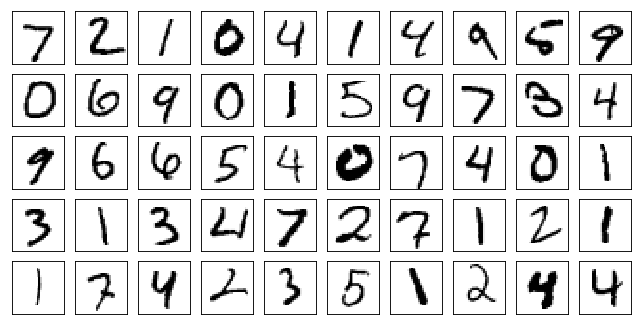

Выход декодера


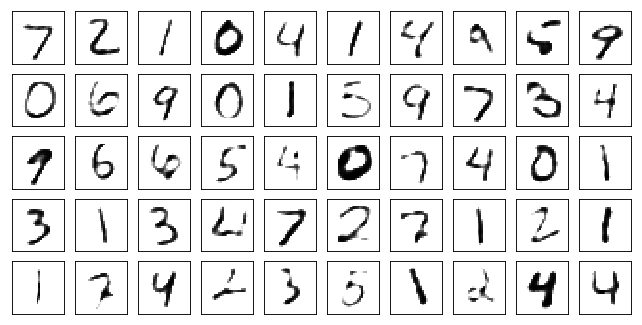

Выход декодера с отсечкой на латентном слое


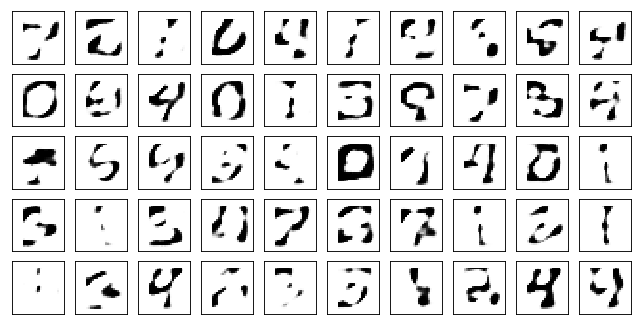

Выход декодера с единичной матрицы


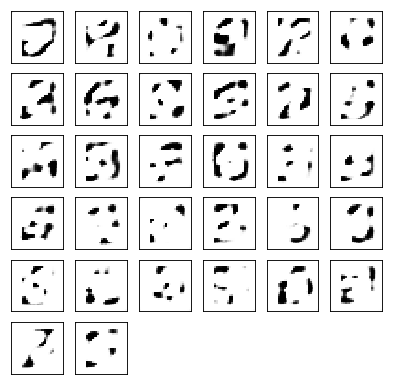

In [10]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (6, 6))

In [11]:
model = torch.load('./adam_bn_l1')

In [12]:
data, _ = next(iter(test_loader))
output = model(data)
to_plot = output.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
decoded = model.decode(torch.eye(32))
dec_to_plot = ((decoded.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()
with torch.no_grad():
    encoded = model.encode(data)
    print((np.abs(encoded) > 0.1).sum(1))
    encoded[np.abs(encoded) < 0.1] = 0.
    decoded_f = model.decode(encoded)
    f_to_plot = ((decoded_f.view(-1, 1, 28, 28)+1)*0.5).clamp(0, 1).data.numpy()

tensor([  7,  16,   3,   8,   7,   3,   8,  13,  14,   8,  11,  11,
          5,   6,   3,   9,   6,   5,  11,   7,   7,   7,  10,   9,
          8,  14,  10,   6,   7,   8,   8,   5,   8,  12,   9,  11,
          7,   6,   7,   4,   4,   8,   8,  11,   8,   4,  11,   8,
          8,  12])


Исходные данные


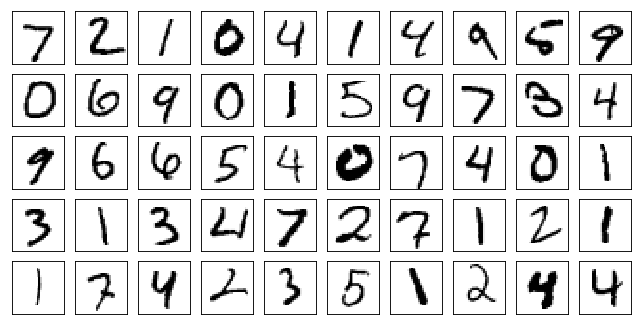

Выход декодера


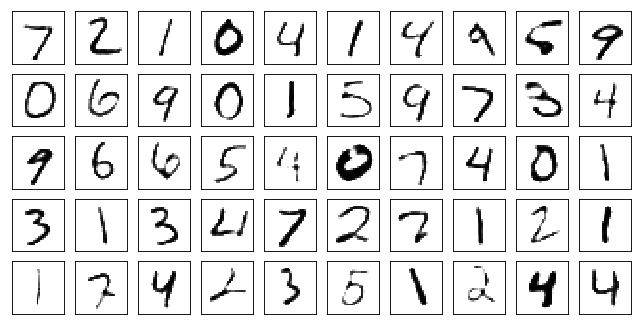

Выход декодера с отсечкой на латентном слое


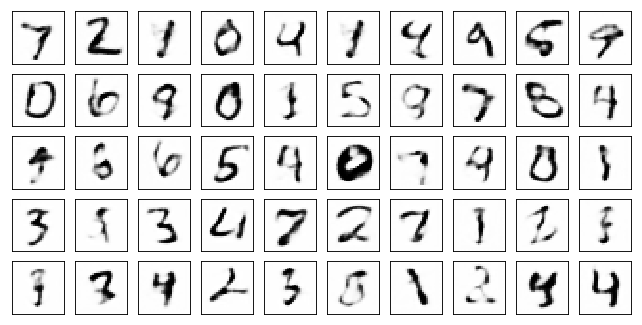

Выход декодера с единичной матрицы


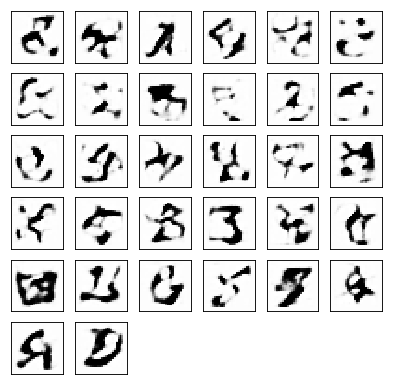

In [13]:
print ("Исходные данные")
plot_mnist(data.data.numpy(), (5, 10))
print ("Выход декодера")
plot_mnist(to_plot, (5, 10))
print ("Выход декодера с отсечкой на латентном слое")
plot_mnist(f_to_plot, (5, 10))
print ("Выход декодера с единичной матрицы")
plot_mnist(dec_to_plot, (6, 6))

### Оптимизация изображений на входе автокодировщика

In [20]:
model = torch.load('./adam_bn_l1')

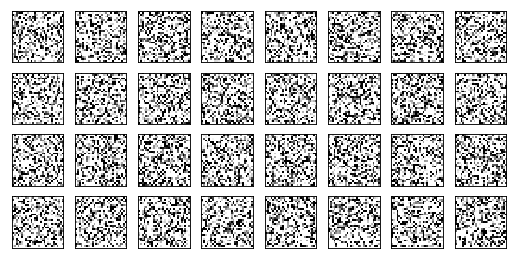

In [21]:
img = torch.randn((32, 784)).view(-1, 1, 28, 28)
to_plot = img.view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
plot_mnist(to_plot, (8, 8))

In [27]:
from torch.autograd import Variable

def generate_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(32)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-3
    
    
    for i in range(1, 100001):  
                
        target = model.encode(F.sigmoid(gen_img_par))
                
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.mse_loss(target, latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
        
                       
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = F.sigmoid(gen_img_par).view(-1, 1, 28, 28).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (8, 8))
                        
    return gen_img_par    

Iteration 5000: loss=0.02480275370180607
Iteration 10000: loss=0.024802446365356445
Iteration 15000: loss=0.024802159518003464
Iteration 20000: loss=0.02480182610452175
Iteration 25000: loss=0.02480154298245907
Iteration 30000: loss=0.02480124868452549
Iteration 35000: loss=0.024800976738333702
Iteration 40000: loss=0.024800725281238556
Iteration 45000: loss=0.024800444021821022
Iteration 50000: loss=0.024800198152661324


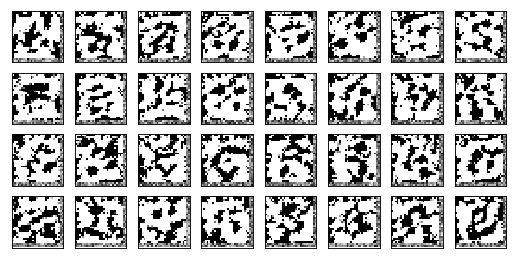

Iteration 55000: loss=0.024799935519695282
Iteration 60000: loss=0.024799708276987076
Iteration 65000: loss=0.024799462407827377
Iteration 70000: loss=0.024799231439828873
Iteration 75000: loss=0.024799007922410965
Iteration 80000: loss=0.02479877695441246
Iteration 85000: loss=0.02479856088757515
Iteration 90000: loss=0.02479836903512478
Iteration 95000: loss=0.024798134341835976
Iteration 100000: loss=0.024797944352030754


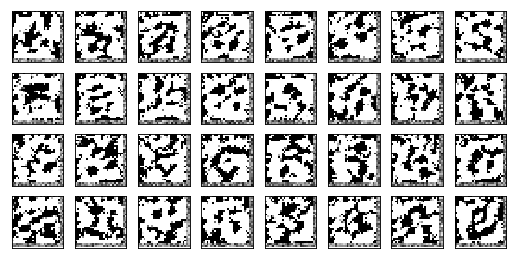

In [28]:
new_image_randn = generate_image(img)

### Оптимизация изображений - фильтры энкодера

In [29]:
def generate_filter_image(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(16)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-4
        
    for i in range(1, 200001):  
                
        target = model._conv1(F.sigmoid(gen_img_par))
        
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        loss = F.mse_loss(target.view(16, 16), latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = F.sigmoid(gen_img_par).view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (4, 4))
                        
    return gen_img_par    

In [30]:
img = torch.randn((16, 16)).view(16, 1, 4, 4)

Iteration 5000: loss=0.2778295874595642
Iteration 10000: loss=0.24105513095855713
Iteration 15000: loss=0.21159961819648743
Iteration 20000: loss=0.18946507573127747
Iteration 25000: loss=0.17371322214603424
Iteration 30000: loss=0.16299356520175934
Iteration 35000: loss=0.15595334768295288
Iteration 40000: loss=0.1514493227005005
Iteration 45000: loss=0.14862032234668732
Iteration 50000: loss=0.1468658596277237


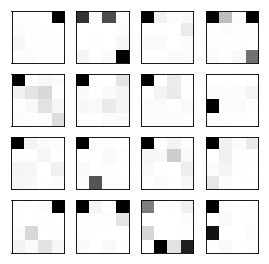

Iteration 55000: loss=0.1457861363887787
Iteration 60000: loss=0.14512449502944946
Iteration 65000: loss=0.14471976459026337
Iteration 70000: loss=0.144472137093544
Iteration 75000: loss=0.14431992173194885
Iteration 80000: loss=0.14422574639320374
Iteration 85000: loss=0.1441667675971985
Iteration 90000: loss=0.14412912726402283
Iteration 95000: loss=0.1441047191619873
Iteration 100000: loss=0.14408829808235168


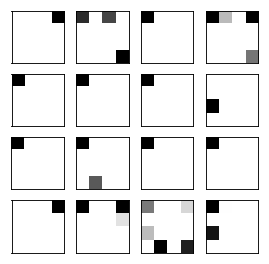

Iteration 105000: loss=0.14407703280448914
Iteration 110000: loss=0.14406900107860565
Iteration 115000: loss=0.1440631002187729
Iteration 120000: loss=0.14405865967273712
Iteration 125000: loss=0.14405518770217896
Iteration 130000: loss=0.14405247569084167
Iteration 135000: loss=0.14405028522014618
Iteration 140000: loss=0.14404845237731934
Iteration 145000: loss=0.14404694736003876
Iteration 150000: loss=0.1440456062555313


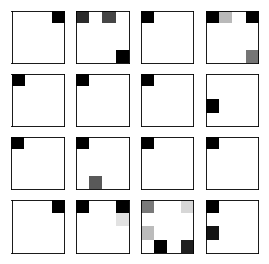

Iteration 155000: loss=0.14404450356960297
Iteration 160000: loss=0.14404357969760895
Iteration 165000: loss=0.14404277503490448
Iteration 170000: loss=0.14404204487800598
Iteration 175000: loss=0.14404135942459106
Iteration 180000: loss=0.14404083788394928
Iteration 185000: loss=0.1440403014421463
Iteration 190000: loss=0.1440398395061493
Iteration 195000: loss=0.14403942227363586
Iteration 200000: loss=0.1440390795469284


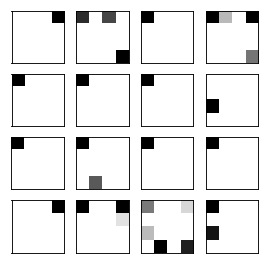

In [31]:
filter_img = generate_filter_image(img)

In [72]:
def generate_filter_image_conv2(img):
    
    gen_img_par = Variable(img, requires_grad=True)
    latent_vector = torch.eye(32)
    loss_stats = []
    steps_since_lr_decreased = 0
    lr = 1e-4
        
    for i in range(1, 200001):  
                
        target = model._conv2(F.sigmoid(gen_img_par))
        
        gen_optim = optim.Adam([gen_img_par], lr=lr, weight_decay=0.)
        gen_optim.zero_grad()
        #print ("TR=",target.shape)
        #print ("LT=", latent_vector.shape)
        loss = F.mse_loss(target.view(32, 32), latent_vector)    
        loss.backward()                   
        gen_optim.step()
        
        if i % 5000 == 0:    
            print ("Iteration {}: loss={}".format(i,loss))
            ls = loss.detach().numpy()            
            loss_stats.append(ls)
                        
            if len(loss_stats) > 10:    
                down = False    
                for k in range(2, 7):    
                    if ls < loss_stats[-k]:
                        down = True
                        break
                # Loss is rising for 5 last epochs - decrease LR
                if not down and steps_since_lr_decreased > 10:
                    lr = lr * 0.5
                    steps_since_lr_decreased = 0
                    print ("Decreasing LR ..")
                    if lr < 1e-6:
                        print ("Stop ..")
                        break
                
                steps_since_lr_decreased += 1

        if i % 50000 == 0:
            to_plot = F.sigmoid(gen_img_par).view(-1, 1, 4, 4).clamp(0, 1).data.numpy()
            plot_mnist(to_plot, (16, 32))
                        
    return gen_img_par    

In [73]:
img = torch.randn((16, 32*4*4)).view(-1, 16, 4, 4)

Iteration 5000: loss=0.16185621917247772
Iteration 10000: loss=0.07211052626371384
Iteration 15000: loss=0.01927936263382435
Iteration 20000: loss=0.002232256578281522
Iteration 25000: loss=0.00035675891558639705
Iteration 30000: loss=0.0001317907590419054
Iteration 35000: loss=7.360509334830567e-05
Iteration 40000: loss=5.022249024477787e-05
Iteration 45000: loss=3.812750946963206e-05
Iteration 50000: loss=3.084613126702607e-05


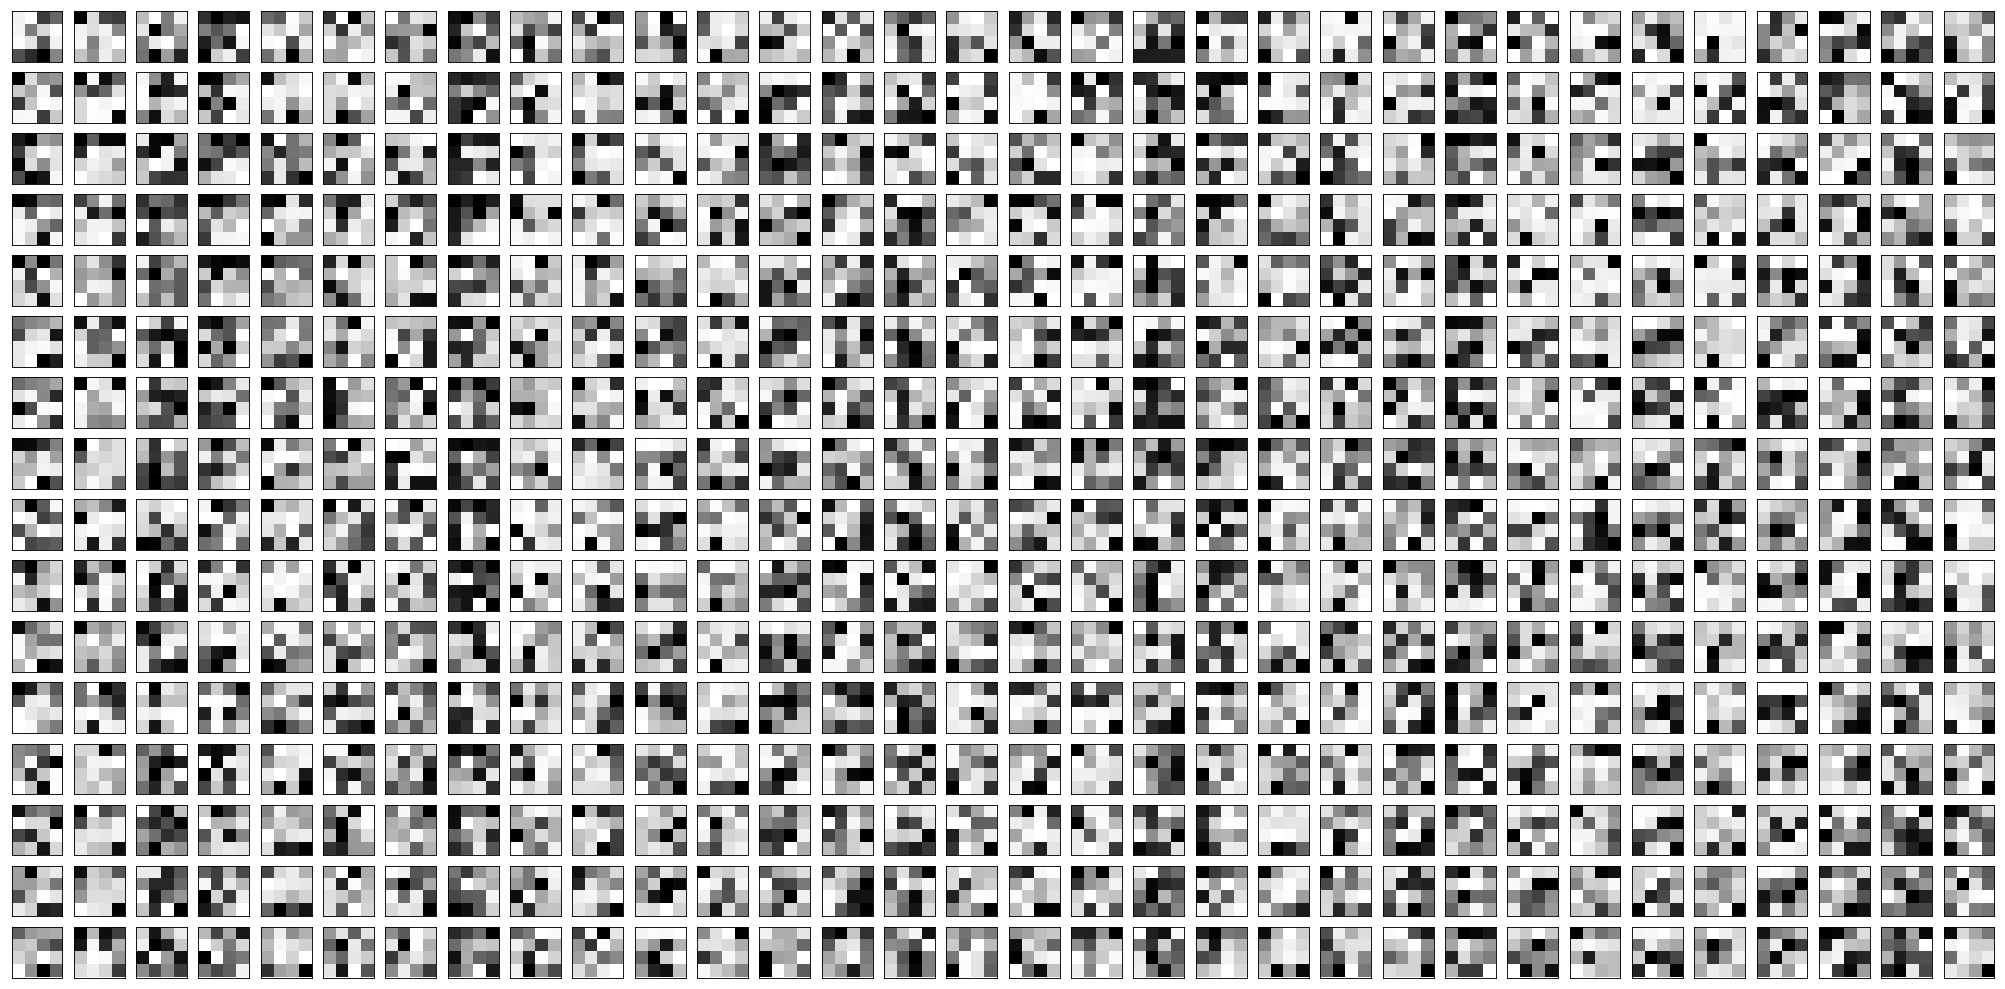

Iteration 55000: loss=2.6009269276983105e-05
Iteration 60000: loss=2.2569789507542737e-05
Iteration 65000: loss=1.9999724827357568e-05
Iteration 70000: loss=1.8005890524364077e-05
Iteration 75000: loss=1.641304334043525e-05
Iteration 80000: loss=1.5110340427781921e-05
Iteration 85000: loss=1.4024307347426657e-05
Iteration 90000: loss=1.3104301615385339e-05
Iteration 95000: loss=1.2314470041019376e-05
Iteration 100000: loss=1.1628408174146898e-05


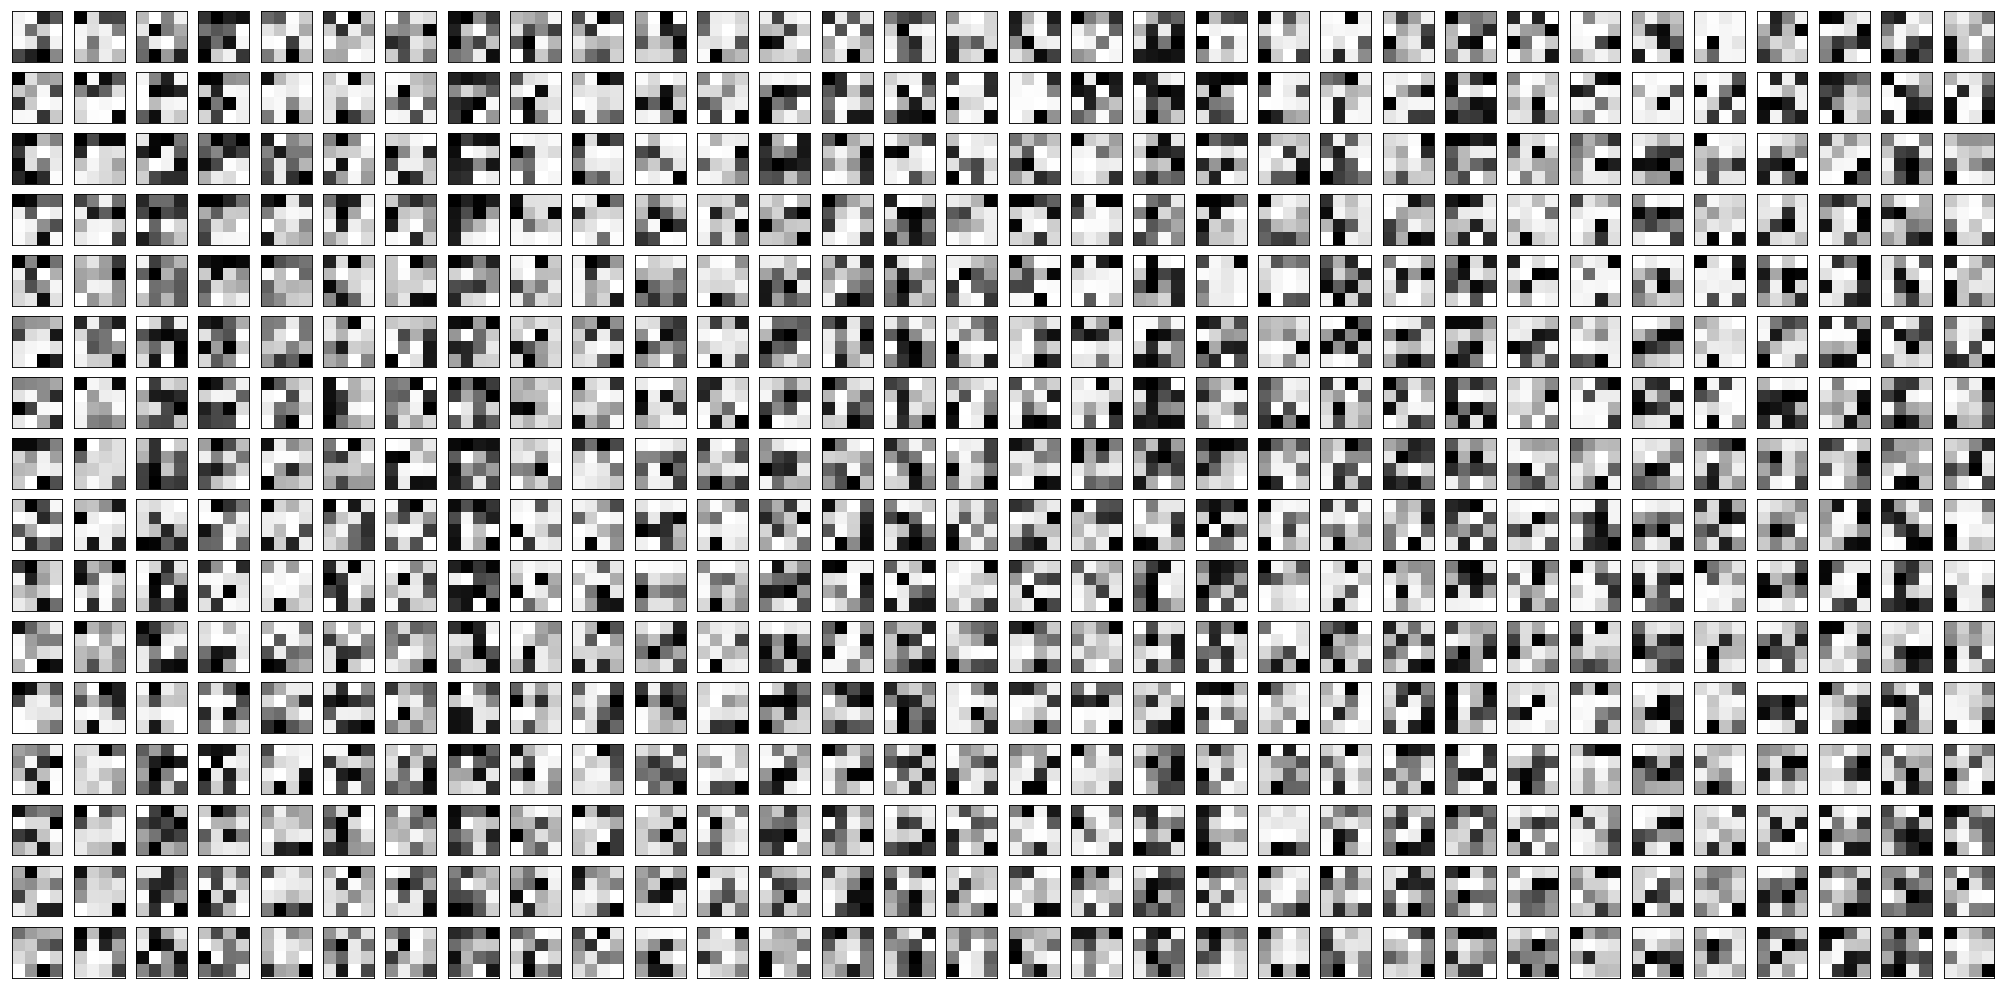

Iteration 105000: loss=1.1026618267351296e-05
Iteration 110000: loss=1.0494093658053316e-05
Iteration 115000: loss=1.0019267392635811e-05
Iteration 120000: loss=9.593117283657193e-06
Iteration 125000: loss=9.208354640577454e-06
Iteration 130000: loss=8.858940418576822e-06
Iteration 135000: loss=8.54016707307892e-06
Iteration 140000: loss=8.247995538113173e-06
Iteration 145000: loss=7.979110705491621e-06
Iteration 150000: loss=7.730897777946666e-06


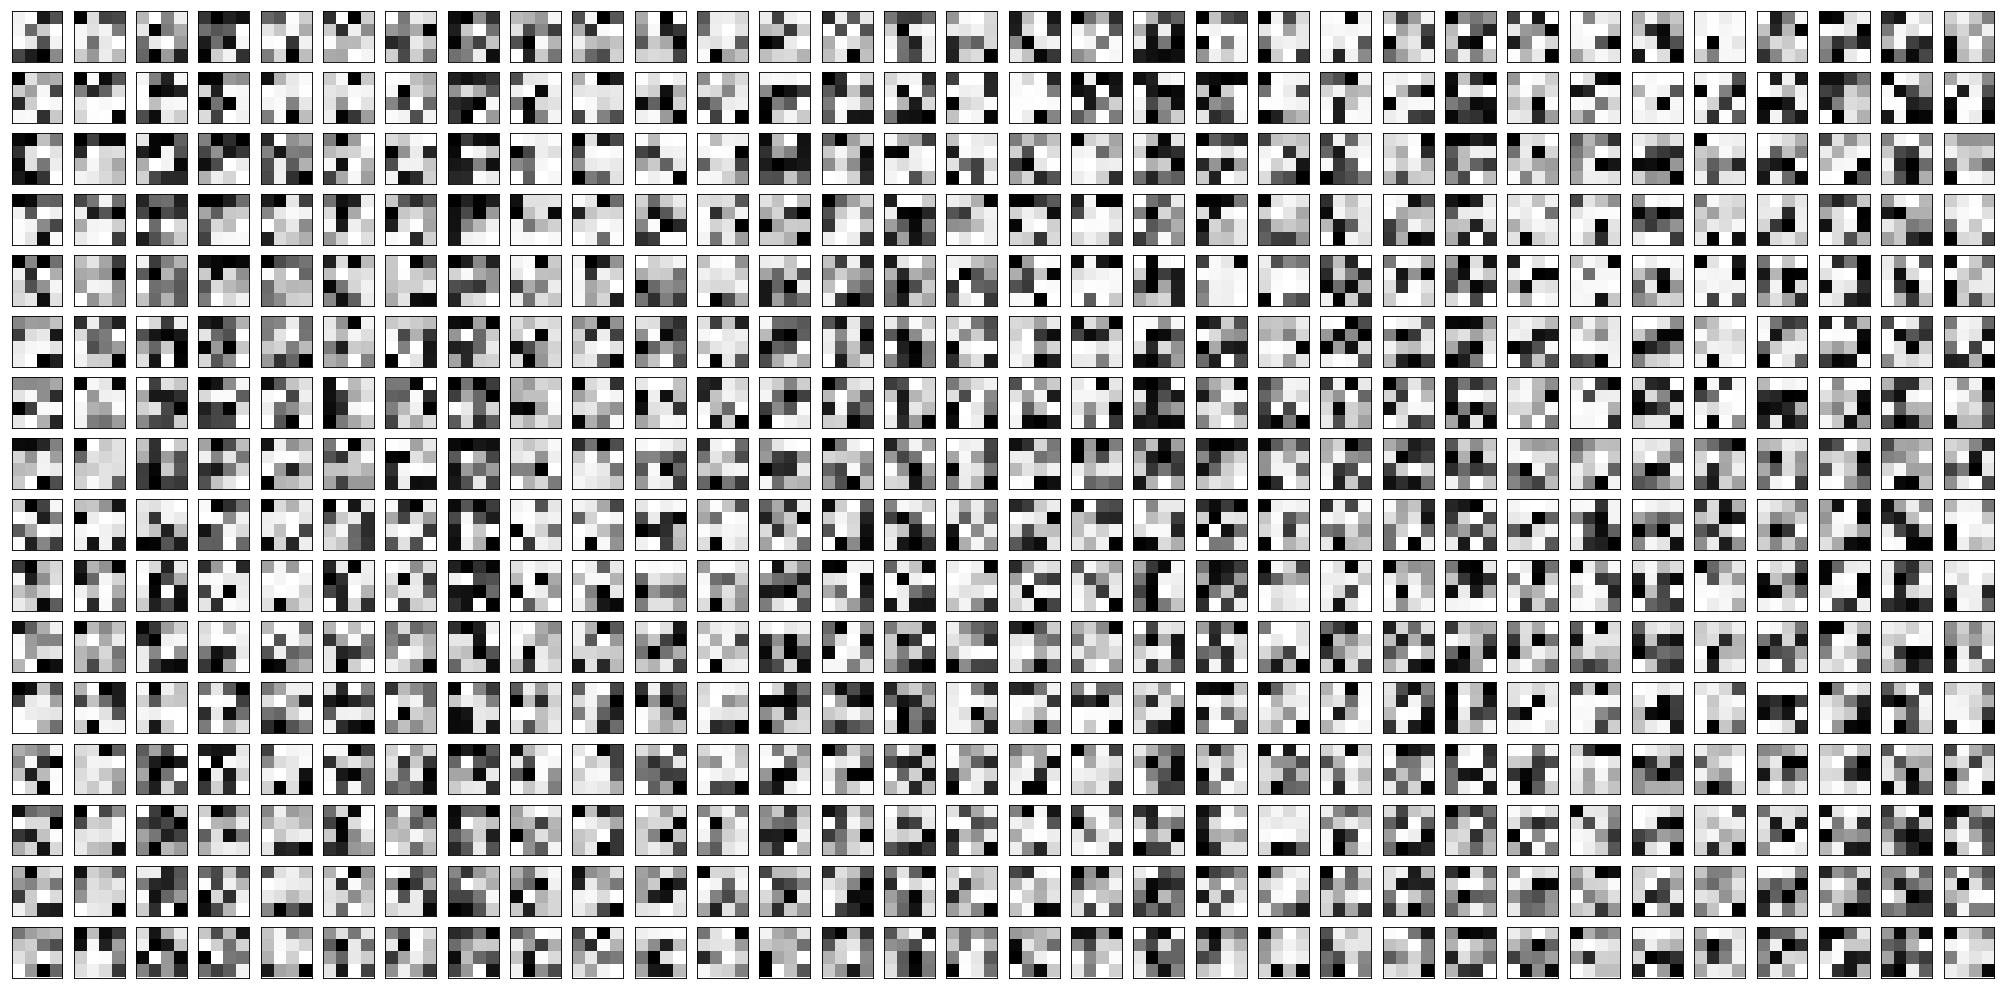

Iteration 155000: loss=7.5009461397712585e-06
Iteration 160000: loss=7.287140761036426e-06
Iteration 165000: loss=7.087983249220997e-06
Iteration 170000: loss=6.901729193486972e-06
Iteration 175000: loss=6.727207164658466e-06
Iteration 180000: loss=6.563459464814514e-06
Iteration 185000: loss=6.409325578715652e-06
Iteration 190000: loss=6.263876912271371e-06
Iteration 195000: loss=6.12653866483015e-06
Iteration 200000: loss=5.99653685640078e-06


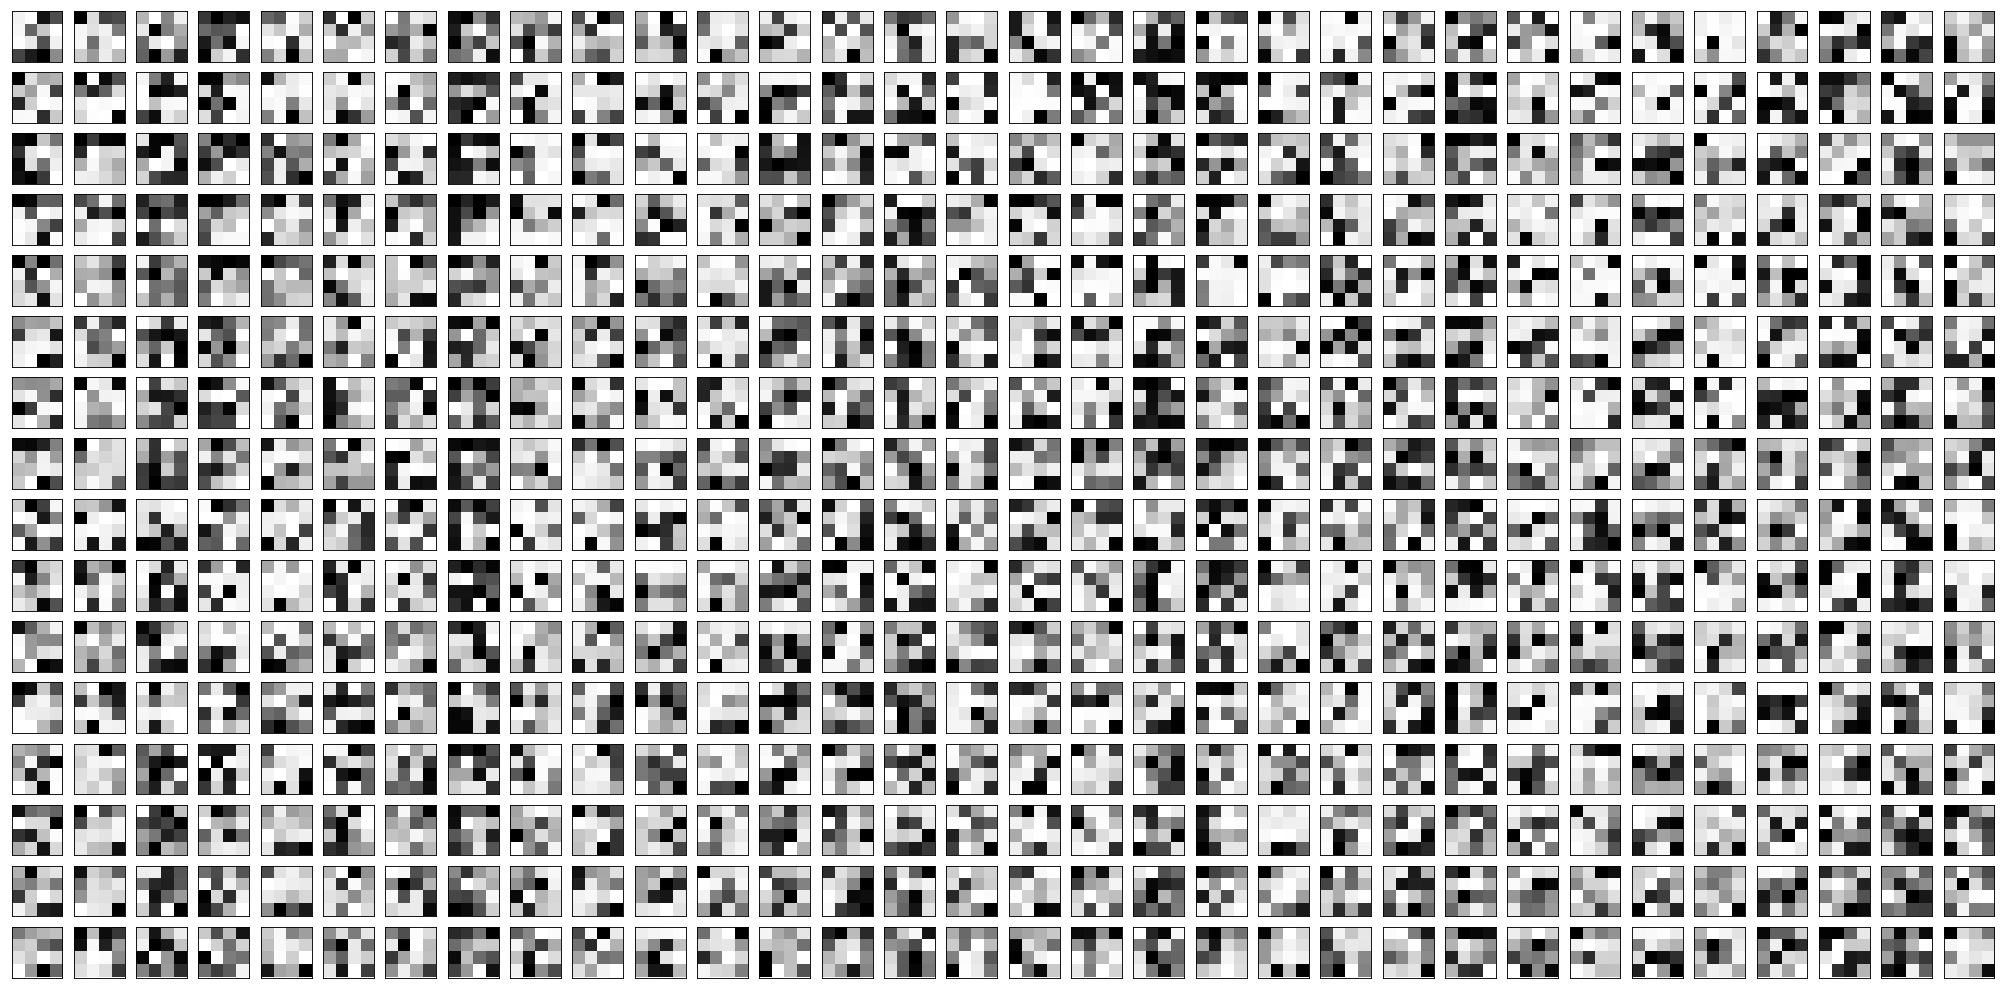

In [74]:
filter_img = generate_filter_image_conv2(img)